In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.integrate import solve_ivp
from scipy.integrate import ode
import time
from numba import njit
m = open('prion_model_ODE.net','r')

In [26]:
mLines = m.readlines()

for i in range(len(mLines)):
    
    if ('begin' in mLines[i])&('parameters' in mLines[i]):
        parInit = i+1
        
    if ('end' in mLines[i])&('parameters' in mLines[i]):
        parEnd = i
    
    if ('begin' in mLines[i])&('reactions' in mLines[i]):
        reactInit = i+1
        
    if ('end' in mLines[i])&('reactions' in mLines[i]):
        reactEnd = i
        
    if ('begin' in mLines[i])&('species' in mLines[i]):
        speciesInit = i+1
        
    if ('end' in mLines[i])&('species' in mLines[i]):
        speciesEnd = i    
    
parLines = mLines[parInit:parEnd]
lines = mLines[reactInit:reactEnd]  
speciesLines = mLines[speciesInit:speciesEnd]  
numPars = len(parLines)

for parID in range(len(parLines)):
    
    parLines[parID]=parLines[parID].replace("^","**")
    
    separated= parLines[parID].split(' ')
    
    for index in range(len(separated)-1,-1,-1):
        
        if len(separated[index])==0:
            del separated[index]

    exec(separated[1]+'='+separated[2])

numSpecies = len(speciesLines)
IC= np.zeros((numSpecies,))

for speciesID in range(numSpecies):
    
    separated= speciesLines[speciesID].split(' ')
    
    for index in range(len(separated)-1,-1,-1):
        
        if len(separated[index])==0:
            del separated[index]

    exec('IC[speciesID]='+separated[2])


reactants = np.zeros((len(lines),10))
products = np.zeros((len(lines),10))

rates = np.zeros((len(lines), ))

for reactionID in range(len(lines)):
    
    separated= lines[reactionID].split(' ')
    
    for index in range(len(separated)-1,-1,-1):
        
        if len(separated[index])==0:
            del separated[index]
            
    reactantSet = separated[1].split(',')
    reactants[reactionID][0]=len(reactantSet)
    
    for reactantID in range(len(reactantSet)):
        reactants[reactionID][reactantID+1] = int(reactantSet[reactantID])-1
        
    productSet = separated[2].split(',')
    products[reactionID][0]=len(productSet)
    
    for productID in range(len(productSet)):
        products[reactionID][productID+1] = int(productSet[productID])-1
    
    rates[reactionID]=eval(separated[3])

reactants=reactants.astype('int')
products=products.astype('int')
        

In [27]:
@njit
def dX(t,X):

    dx = np.zeros((numSpecies,))
    
    for i in range(numReactions):

        flux = rates[i]
        
        for j in range(1, reactants[i][0]+1):
            
            flux = flux*X[reactants[i][j]]
        
        for j in range(1, reactants[i][0]+1):

            dx[ reactants[i][j] ]  -= flux
            
        for j in range(1, products[i][0]+1):

            dx[ products[i][j] ]  += flux

    return dx

In [37]:
tStart = time.time()
method='LSODA'
tSpan = np.linspace(0,300,30001)
tol = 1e-6
sol = solve_ivp(dX,(0,tSpan[-1]),IC,t_eval=tSpan,method=method,rtol=tol,atol=tol)
tEnd = time.time()

print(tEnd-tStart)

1.2175288200378418


In [38]:
bng = np.genfromtxt('prion_model_ODE.cdat')
bng_t = bng[:,0]
bng_x = bng[:,1:].T

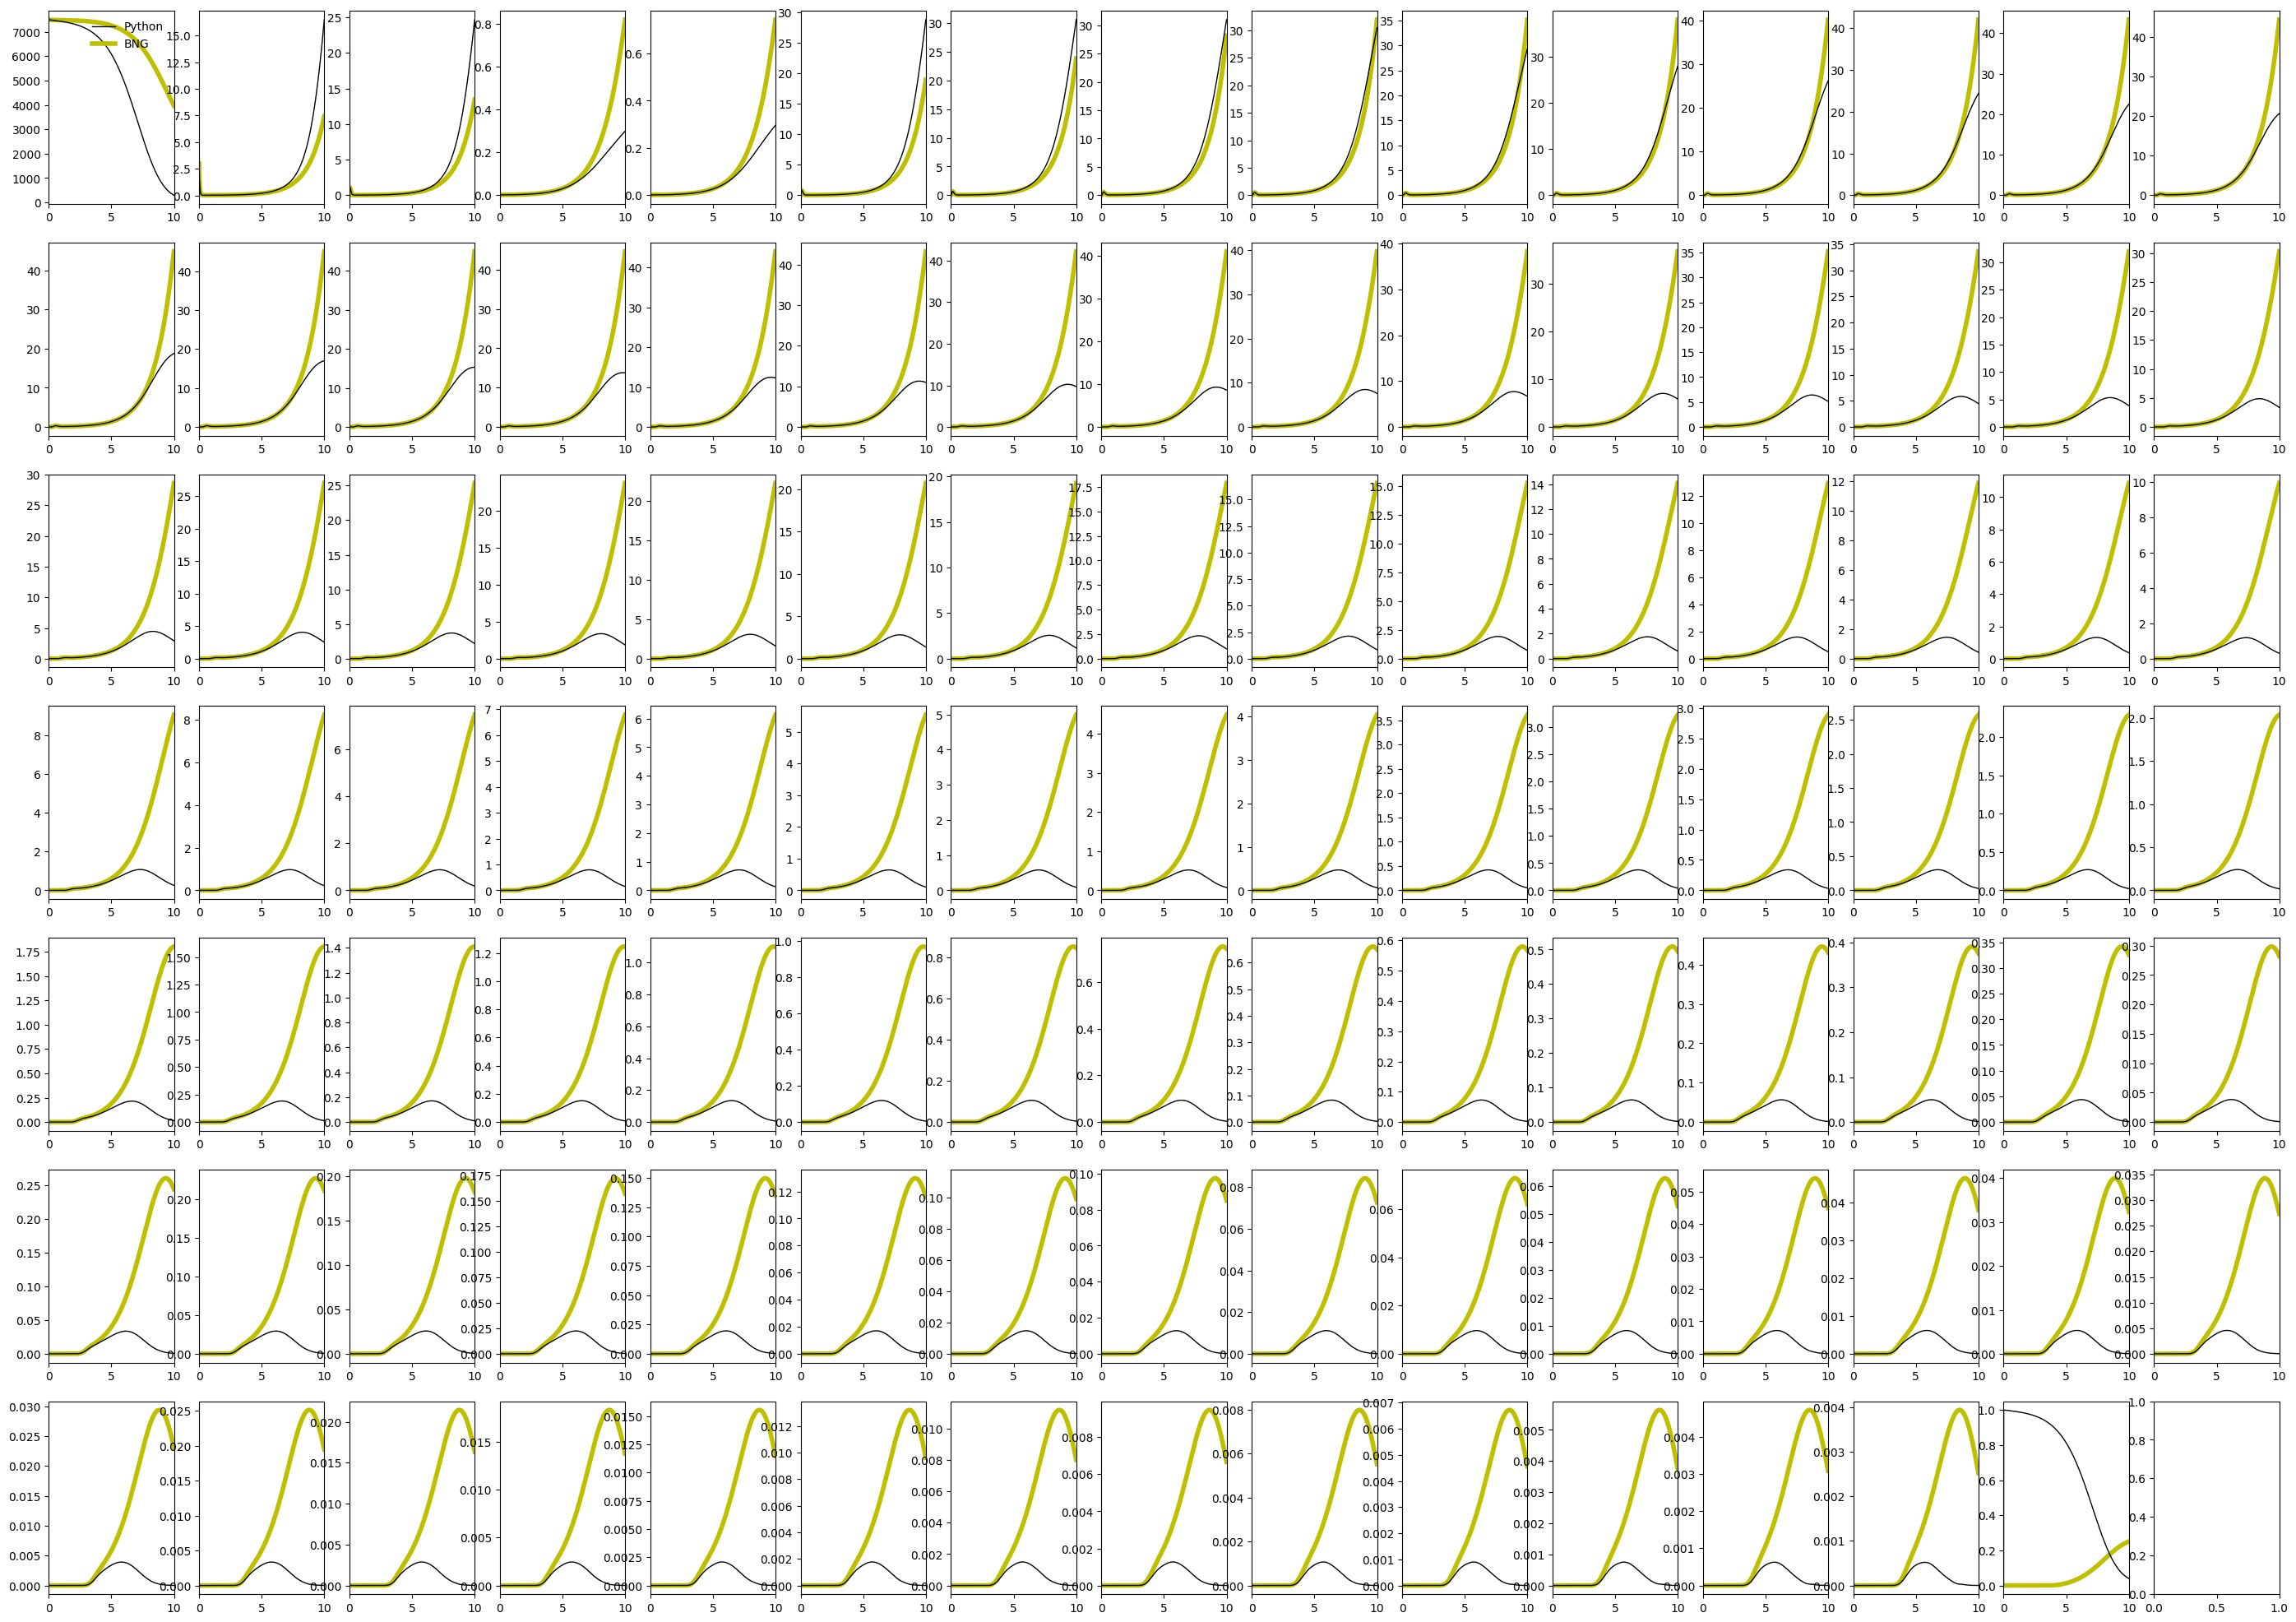

In [42]:
fig,ax = plt.subplots(7,15,figsize=(35,25))
t_end = 1000

for i in range(7):
    for j in range(15):
        index = i*15+j
        if index<104:
            ax[i][j].plot(sol.t[:t_end], sol.y[index,:t_end],zorder=2, lw=1, color='k', label='Python')
            ax[i][j].plot(bng_t[:t_end], bng_x[index,:t_end],zorder=1, lw=4, color='y', label='BNG')
            ax[i][j].set_xlim(sol.t[[0,t_end]])
            if index==0:
                ax[i][j].legend(loc=1, frameon=False)